In [1]:
from collections import defaultdict
import os

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import scipy.linalg
import torch
import torch.nn.functional as F
import sklearn.cluster

from datasets import load_dataset
from transformers import AutoTokenizer, GPTNeoXForCausalLM

In [5]:
with open("/om/user/ericjm/results/the-everything-machine/clustering-0/clusters_full_more.pkl", 'rb') as f:
    clusters = pickle.load(f)

In [6]:
idxs, C, C_abs = torch.load("/om/user/ericjm/results/the-everything-machine/clustering-0/full_more.pt")

In [7]:
C = C.cpu().numpy()
C_abs = C_abs.cpu().numpy()
C = 1 - np.arccos(C) / np.pi

In [8]:
clusters_labels, _ = clusters[400]
label_frequencies = defaultdict(int)
for l in clusters_labels:
    label_frequencies[l] += 1


In [9]:
labels_sorted_by_freq = sorted(label_frequencies.keys(), key=lambda k: label_frequencies[k], reverse=True)
# label_permutation = [labels_sorted_by_freq.index(i) for i in labels_sorted_by_freq]

In [10]:
permutation = []
indices = defaultdict(list)
for i, cls in enumerate(clusters_labels):
    indices[cls].append(i)
for cls in labels_sorted_by_freq:
    permutation.extend(indices[cls])

In [11]:
C_ordered = C[permutation, :][:, permutation]

0it [00:00, ?it/s]

/tmp/ipykernel_44408/509804235.py:59: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


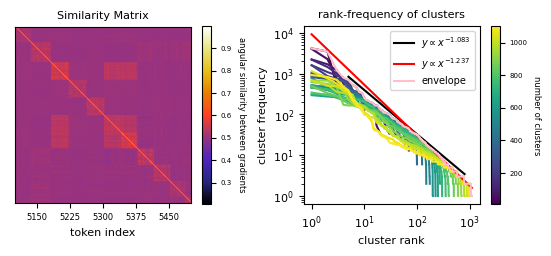

In [42]:
plt.figure(figsize=(5.5, 2.5))

plt.subplot(1, 2, 1)
plt.imshow(C_ordered, cmap='CMRmap', vmin=C.min(), vmax=C.max())
i0, i1 = 5100, 5500
plt.xlim(i0, i1)
plt.ylim(i1, i0)

# add colorbar with label "angular similarity between gradients"
cbar = plt.colorbar()
cbar.ax.set_ylabel('angular similarity between gradients', rotation=270, labelpad=10, fontsize=6)
cbar.ax.tick_params(labelsize=5)
plt.xticks(list(range(i0+50, i1, 75)), fontsize=6)
# plt.yticks(list(range(i1-50, i0+50, -75)), fontsize=6)
plt.yticks([])
plt.xlabel('token index', fontsize=8)
# plt.ylabel('token index', fontsize=6)
plt.title("Similarity Matrix", fontsize=8)



ax = plt.subplot(1, 2, 2)

all_freqs = defaultdict(list)

cluster_numbers = sorted(list(clusters))
colors = plt.cm.viridis(np.linspace(0, 1, len(cluster_numbers)))
for i, n_clusters in tqdm(enumerate(sorted(list(clusters)))):
    clusters_labels, _ = clusters[n_clusters]
    label_frequencies = defaultdict(int)
    for l in clusters_labels:
        label_frequencies[l] += 1
    freqs = sorted(list(label_frequencies.values()), reverse=True)

    xs = list(range(1, 1+len(freqs)))
    ys = freqs
    for x, y in zip(xs, ys):
        all_freqs[x].append(y)
    plt.plot(xs, ys, color=colors[cluster_numbers.index(n_clusters)]) # label=n_clusters if i % 3 == 0 else None) #label='activation clustering freqs')


line_ys = 4800 * np.power(xs[4:800], -1.083)
plt.plot(xs[4:800], line_ys, color='black', label="$y\propto x^{-1.083}$")
    
envelope = np.array([max(all_freqs[x]) for x in xs])

i0, i1 = 100, 1000
reg = LinearRegression().fit(np.log(xs[i0:i1]).reshape(-1, 1), np.log(envelope[i0:i1]))
reg_ys = np.exp(reg.intercept_) * np.power(xs, reg.coef_[0])
plt.plot(xs, reg_ys, color='red', label=f"$y\propto x^{{{reg.coef_[0]:.3f}}}$")

plt.plot(xs, envelope, color='pink', label="envelope")

# plt.plot(xs[i0:i1], reg_ys, color='black', zorder=-10, label=f"$y\propto x^{{{reg.coef_[0]:.3f}}}$")

# add a colorbar for the n_clusters to ax
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=cluster_numbers[0], vmax=cluster_numbers[-1]))
sm._A = []
cbar = plt.colorbar(sm)
cbar.ax.set_ylabel('number of clusters', rotation=270, labelpad=10, fontsize=6)
cbar.ax.tick_params(labelsize=5)

plt.xlabel("cluster rank", fontsize=8)
plt.ylabel("cluster frequency", fontsize=8)
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=7, loc='upper right')
plt.xticks([1e0, 1e1, 1e2, 1e3], fontsize=8)
plt.yticks(fontsize=8)

# add grey dashed grid lines
# plt.grid(which='both', axis='both', linestyle='dashed', linewidth=0.5, color='grey')
plt.title("rank-frequency of clusters", fontsize=8)

# plt.subplots_adjust(hspace=100.0)
plt.tight_layout(pad=0.5)
plt.savefig("../../figures/similarity-matrix-and-rank-frequency-envelope.png", dpi=300)



In [12]:
# iterate through matploblic cmaps
for cmap in tqdm(plt.colormaps()[30:]):

    plt.figure(figsize=(2.5, 2.5))

    plt.subplot(1, 1, 1)
    plt.imshow(C_ordered, cmap=cmap, vmin=C.min(), vmax=C.max())
    i0, i1 = 5100, 5500
    plt.xlim(i0, i1)
    plt.ylim(i1, i0)

    # add colorbar with label "angular similarity between gradients"
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('angular similarity between gradients', rotation=270, labelpad=10, fontsize=6)
    cbar.ax.tick_params(labelsize=5)
    plt.xticks(list(range(i0+50, i1-50, 75)), fontsize=6)
    plt.yticks(list(range(i1-50, i0+50, -75)), fontsize=6)
    plt.xlabel('token index', fontsize=6)
    plt.ylabel('token index', fontsize=6)
    plt.title("Similarity Matrix", fontsize=8)
    plt.savefig(f"../../tmp/cmap-similaritymatrix/{cmap}.png", dpi=250)
    plt.close()

  0%|          | 0/136 [00:00<?, ?it/s]

: 

: 

0it [00:00, ?it/s]

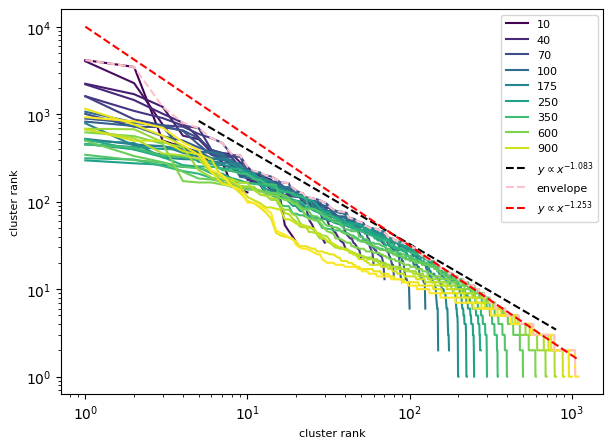

In [10]:
plt.figure(figsize=(7, 5))

all_freqs = defaultdict(list)

cluster_numbers = sorted(list(clusters))
colors = plt.cm.viridis(np.linspace(0, 1, len(cluster_numbers)))
for i, n_clusters in tqdm(enumerate(sorted(list(clusters)))):
    clusters_labels, _ = clusters[n_clusters]
    label_frequencies = defaultdict(int)
    for l in clusters_labels:
        label_frequencies[l] += 1
    freqs = sorted(list(label_frequencies.values()), reverse=True)

    xs = list(range(1, 1+len(freqs)))
    ys = freqs
    for x, y in zip(xs, ys):
        all_freqs[x].append(y)
    plt.plot(xs, ys, color=colors[cluster_numbers.index(n_clusters)], label=n_clusters if i % 3 == 0 else None) #label='activation clustering freqs')


line_ys = 4800 * np.power(xs[4:800], -1.083)
plt.plot(xs[4:800], line_ys, color='black', linestyle='dashed', label="$y\propto x^{-1.083}$")
    
envelope = np.array([max(all_freqs[x]) for x in xs])
plt.plot(xs, envelope, color='pink', linestyle='dashed', label="envelope")

i0, i1 = 100, 900
reg = LinearRegression().fit(np.log(xs[i0:i1]).reshape(-1, 1), np.log(envelope[i0:i1]))
reg_ys = np.exp(reg.intercept_) * np.power(xs, reg.coef_[0])
plt.plot(xs, reg_ys, color='red', linestyle='dashed', label=f"$y\propto x^{{{reg.coef_[0]:.3f}}}$")
 
# plt.plot(xs[i0:i1], reg_ys, color='black', zorder=-10, label=f"$y\propto x^{{{reg.coef_[0]:.3f}}}$")

plt.xlabel("cluster rank", fontsize=8)
plt.ylabel("cluster rank", fontsize=8)
plt.yscale('log')
plt.xscale('log')
plt.legend(fontsize=8, loc='upper right')
# plt.savefig("../../figures/llm-envelope-slope-measurement.png", dpi=250)